# Testing Harris corner detector on a checkerboard

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

In [2]:
img = cv.imread('Checkerboard-A4-30mm-8x6.png')

In [3]:
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.04)
kernel = np.ones((5,5),np.uint8)
dst = cv.dilate(dst,None)
img[dst>0.1*dst.max()]=[0,0,255]

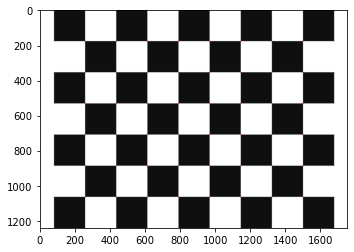

True

In [4]:
imgshow = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(imgshow), plt.show()
cv.imwrite('harris_keypoints.jpg',img)

In [5]:
#crashing... Don't run in jupyter
#cv.imshow('dst',img)
#if cv.waitKey(0) & 0xff == 27:
#    cv.destroyAllWindows()



# Testing SIFT features

In [6]:
#img = cv.imread('rose.jpg')
img = cv.imread('Checkerboard-A4-30mm-8x6.png')

In [7]:
gray=cv.cvtColor(img,cv.COLOR_BGR2GRAY)

In [8]:
sift = cv.xfeatures2d.SIFT_create()

In [9]:
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img)
cv.imwrite('sift_keypoints.jpg',img)

True

# Some opencv basic examples

In [10]:
img = cv.imread('rose.png')

In [11]:
print("Image Properties")
print("- Number of Pixels: " + str(img.size))
print("- Shape/Dimensions: " + str(img.shape))

Image Properties
- Number of Pixels: 2782440
- Shape/Dimensions: (1180, 786, 3)


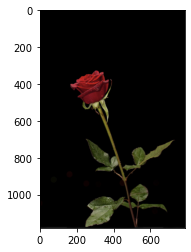

In [12]:
imgrgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
plt.imshow(imgrgb)
plt.show()

# SIFT feature matching demo using RANSAC

In [13]:
MIN_MATCH_COUNT = 10

img1 = cv.imread('box.png',0)          # queryImage
img2 = cv.imread('box_in_scene.png',0) # trainImage

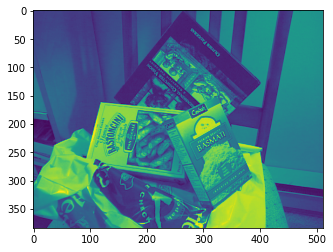

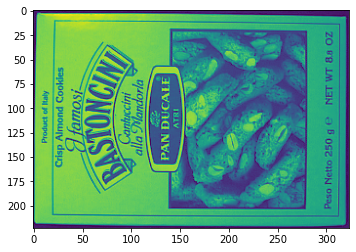

In [14]:
plt.imshow(img2)
plt.show()
plt.imshow(img1)
plt.show()

In [15]:
# Initiate SIFT detector
sift = cv.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)


In [16]:
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)

flann = cv.FlannBasedMatcher(index_params, search_params)

matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [17]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()

    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)

    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)

else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None

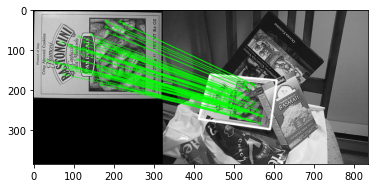

True

In [18]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.imshow(img3, 'gray'),plt.show()
cv.imwrite('SIFT_matches.jpg',img3)

# Testing Optical Flow: Lucas-Kanade Approach

In [19]:
cap = cv.VideoCapture('slow_traffic_small.mp4')
fourcc = cv.VideoWriter_fourcc(*'XVID')
out = cv.VideoWriter('output.avi',fourcc, 20.0, (640,360))

In [20]:
# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

In [21]:

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
#using the ShiTomasi corner detection
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)
t=0

In [22]:
while(t<900):
    t+=1
    ret,frame = cap.read()
    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv.add(frame,mask)

    #again, do this only if in a python file outside jupyter
    #cv.imshow('frame',img)
    #k = cv.waitKey(30) & 0xff
    #if k == 27:
    #    break

    #If you want to see the output in jupyter notebook, uncomment the following two lines
    #imgshow = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    #plt.imshow(imgshow), plt.show()
    
    out.write(img)
    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

In [23]:
cap.release()
out.release()